In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import caustics
from IPython.display import HTML
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Building a Microlensing Simulator

This documentation provides an overview of how to build your own `Simulator`. In this tutorial, we will use the ray tracing tools within the `caustics` library applied to [microlensing](https://www.microlensing-source.org/concept/). We will cover:

1.	Creating a custom microlensing `Simulator`
2.  Setting up the parameters for our custom sim
3.  Running batched, dynamic simulations and visualizing the results

By the end of this guide, you will hopefully feel empowered to create your own custom `Simulator` for your use case!

## Setting up the `Lens`, `Source`, and `Cosmology` environment

We will be using a Point lens model and a StarSource light source model provided by `caustics`. We also must define a cosmology environment, which, `caustics` uses to calculate cosmological evolution at large distances. Here, we define a `FlatLambdaCDM` cosmology. But since we only typically care about redshift $z\approx0$ for microlensing, the cosmology will not actually matter.

In [13]:
cosmology = caustics.FlatLambdaCDM()
point_lens = caustics.Point(cosmology=cosmology, name="lens")
src = caustics.StarSource(name="source")

In [14]:
#Define the pixel grid for imaging
n_pix = 100
res = 0.05
upsample_factor = 10
theta_x, theta_y = caustics.utils.meshgrid(
    res / upsample_factor,
    upsample_factor * n_pix,
    dtype=torch.float32,
)

## Building our `Simulator`

Here we define a Microlens class that extends caustics.Simulator. Generically, the child class is where you define all the methods necessary to run your simulation, which is done in the `forward` method. This allows us to run the simulator by passing a single argument, the `params` dictionary, and the `caustics` backend handles the rest.

In our case, we use our simulator to calculate the magnification of a source at a given position, as well as the lensed image(s) (by definition, multiple images are unresolvable in microlenisng). 

In [15]:
class Microlens(caustics.Simulator):
    def __init__(
        self, lens, src, theta_x=None, theta_y=None, z_s=None, name: str = "sim"
    ):
        super().__init__(name)
        self.lens = lens
        self.src = src

        #Define static parameters that need to be used in forward
        self.add_param("theta_x", theta_x)
        self.add_param("theta_y", theta_y)
        self.add_param("z_s", z_s)

    def forward(self, params):
        theta_x, theta_y, z_s = self.unpack(params)
        #Compute the observed positions of the source
        beta_x, beta_y = self.lens.raytrace(theta_x, theta_y, z_s, params)
        #Compute the brightness of the source at the observed positions (the image)
        brightness = self.src.brightness(beta_x, beta_y, params)
        #Compute the baseline (unlensed) brightness of the source
        baseline_brightness = self.src.brightness(theta_x, theta_y, params)
        #Return the lensed image [n_pix x n_pix], and magnification 
        return brightness, brightness.mean() / baseline_brightness.mean()

Now we can visualize the structure of our simulator

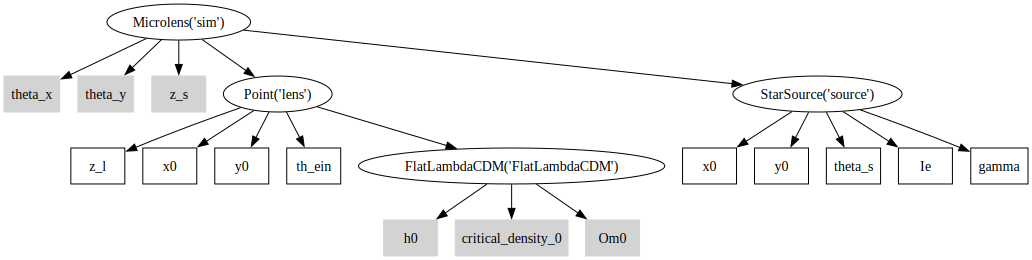

In [16]:
sim = Microlens(point_lens, src, theta_x=theta_x, theta_y=theta_y, z_s=0.0)
sim.graph(True, True)

Now we can set up the parameters for our simulation. We can look at the order of the parameters expected by our simulator by looking at `x_order`.

In [17]:
sim.x_order

['lens.z_l',
 'lens.x0',
 'lens.y0',
 'lens.th_ein',
 'source.x0',
 'source.y0',
 'source.theta_s',
 'source.Ie',
 'source.gamma']

In [18]:
# Microlensing Physical Parameters
th_ein = 0.3  # Einstein radius in arcsec

# Microlensing Model Parameters
t0 = 0.2  # time at peak magnification
u0 = 0.5  # minimum impact parameter (u(t=t_0)) in units of th_ein
tE = 0.05  # Einstein timescale
# rho = 3.0  # source size in units of lens Einstein radii
rho = 2.0  # source size in units of lens Einstein radii

gamma = 0.0  # linear limb darkening coefficient

In [19]:
B = 64  # Batch size
ts = torch.linspace(-6 * tE + t0, 6 * tE + t0, B).view(-1, 1)  # Create time grid

# Calculate source position at each time in arcsec
x0s = (ts - t0) / (tE) * th_ein  # Shape is [B, 1]

# Since source is assumed radially symmetric, can set all motion in the x direction
y0s = -u0 * th_ein * torch.ones_like(x0s)

In [20]:
x = torch.tensor(
    [
        0.0,  # z_l
        0.0,  # x0
        0.0,  # y0
        th_ein,  # th_ein
        0.0,  # x0
        0.0,  # y0
        th_ein * rho,  # theta_s
        5.0,  # Ie,
        gamma,  # gamma
    ]
)

# Create the input tensor for the simulator. In this simple example, everything is static except for the lens position
newx = x.repeat(B, 1)
newx[:, 1] = x0s.view(-1)
newx[:, 2] = y0s.view(-1)

## Running the simulation and visualzing the output

Running a batched simulation over different parameters (in our case, these correspond to the lens motion in discrete time-steps by construction) is now as easy as using `vmap` on our simulator. We can then visualize the total output

In [21]:
images, magnifications = torch.vmap(sim)(newx)

In [22]:
# Create animation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# Display the first frame of the image in the first subplot
img = ax1.imshow(images[0].numpy(), cmap="cividis", interpolation="bilinear")
ax1.set_title("Image")

# Set up the scatter plot for magnifications in the second subplot
scatter = ax2.scatter(ts[0].item(), magnifications[0].item())
ax2.set_xlim(ts.min().item(), ts.max().item())
ax2.set_ylim(magnifications.min().item() * 0.9, magnifications.max().item() * 1.1)
ax2.axvline(-tE / 2, color="r", linestyle="--")
ax2.axvline(tE / 2, color="r", linestyle="--")
ax2.set_xlabel("t")
ax2.set_ylabel("A")


def update(frame):
    """Update function for the animation."""
    # Update the image in the first subplot
    img.set_array(images[frame].numpy())

    # Update the scatter plot in the second subplot
    ax2.clear()  # Clear the previous frame
    ax2.scatter(ts[: frame + 1].numpy(), magnifications[: frame + 1].numpy())
    ax2.set_xlim(ts.min().item(), ts.max().item())
    ax2.set_ylim(magnifications.min().item() * 0.9, magnifications.max().item() * 1.1)
    ax2.axvline(-tE / 2 + t0, color="r", linestyle="--")
    ax2.axvline(tE / 2 + t0, color="r", linestyle="--")
    ax2.set_xlabel("t")
    ax2.set_ylabel("A")
    ax2.set_title("Light-Curve")

    return img, scatter


ani = animation.FuncAnimation(fig, update, frames=B, interval=60)

plt.close()

# Save animation as gif
# ani.save("microlensing_animation.gif", writer='pillow', fps=16)  # Adjust 'fps' for the speed

# Or display the animation inline
HTML(ani.to_jshtml())

In [53]:
#If we want, we can save this data for later use

noise = 0.00 * torch.randn_like(magnifications)
noisy_mags = magnifications + noise
err_mag = 0.02 * torch.ones_like(magnifications)  # set fixed error for now
data = np.vstack((ts.view(-1), noisy_mags, err_mag)).T

# np.savez("assets/microlensing_dat", data=data)